In [1]:
!pip install torch torchvision
!pip install ultralytics
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install pytube
!pip install moviepy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.2 MB/s eta 0:00:00


In [2]:
!pip install pillow

In [3]:
!pip install opencv-python-headless

In [4]:
# Import libraries
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from ultralytics import YOLO
from PIL import Image
import shutil
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Define paths (UPDATE THESE PATHS TO YOUR GOOGLE DRIVE LOCATION)
VIDEO_DIR = '/content/drive/MyDrive/sports_videos'
OUTPUT_DIR = '/content/output'
DETECTED_DIR = f'{OUTPUT_DIR}/detected_videos'
FRAMES_DIR = f'{OUTPUT_DIR}/frames'
RESULTS_DIR = f'{OUTPUT_DIR}/results'

In [8]:
# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DETECTED_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("✓ Directories created successfully")

✓ Directories created successfully


In [10]:
# STEP 3: VIDEO PREPROCESSING
def get_video_info(video_path):
    """Extract video information"""
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps
    cap.release()

    return {
        'fps': fps,
        'frame_count': frame_count,
        'width': width,
        'height': height,
        'duration': duration
    }

def list_videos():
    """List all videos in the directory"""
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    videos = []

    for ext in video_extensions:
        videos.extend(list(Path(VIDEO_DIR).glob(f'*{ext}')))

    return [str(v) for v in videos]

In [11]:
# Get all videos
video_files = list_videos()
print(f"\n✓ Found {len(video_files)} videos")


✓ Found 17 videos


In [12]:
# Display video information
for i, video_path in enumerate(video_files, 1):
    info = get_video_info(video_path)
    print(f"\nVideo {i}: {os.path.basename(video_path)}")
    print(f"  Duration: {info['duration']:.2f}s | Resolution: {info['width']}x{info['height']}")
    print(f"  FPS: {info['fps']} | Frames: {info['frame_count']}")


Video 1: vedio1.mp4
  Duration: 12.14s | Resolution: 720x1280
  FPS: 29 | Frames: 352

Video 2: vedio7.mp4
  Duration: 11.83s | Resolution: 576x1024
  FPS: 30 | Frames: 355

Video 3: vedio5.mp4
  Duration: 15.13s | Resolution: 720x1280
  FPS: 30 | Frames: 454

Video 4: vedio6.mp4
  Duration: 8.69s | Resolution: 720x1280
  FPS: 29 | Frames: 252

Video 5: vedio4.mp4
  Duration: 8.62s | Resolution: 720x1280
  FPS: 50 | Frames: 431

Video 6: vedio3.mp4
  Duration: 18.25s | Resolution: 720x1280
  FPS: 24 | Frames: 438

Video 7: vedio2.mp4
  Duration: 15.12s | Resolution: 720x1280
  FPS: 25 | Frames: 378

Video 8: vedio16.mp4
  Duration: 16.68s | Resolution: 720x1280
  FPS: 25 | Frames: 417

Video 9: vedio14.mp4
  Duration: 8.10s | Resolution: 720x1280
  FPS: 30 | Frames: 243

Video 10: vedio17.mp4
  Duration: 11.64s | Resolution: 720x1280
  FPS: 25 | Frames: 291

Video 11: vedio15.mp4
  Duration: 27.08s | Resolution: 720x1280
  FPS: 25 | Frames: 677

Video 12: vedio13.mp4
  Duration: 15.80

In [13]:
# STEP 4: PLAYER DETECTION USING YOLO
class PlayerDetector:
    def __init__(self, model_name='yolov8n.pt'):
        """Initialize YOLO model for player detection"""
        print(f"\n📦 Loading YOLO model: {model_name}")
        self.model = YOLO(model_name)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"✓ Using device: {self.device}")

    def detect_players(self, video_path, output_path, conf_threshold=0.5):
        """Detect players in video and save output"""
        print(f"\n🎬 Processing: {os.path.basename(video_path)}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        detection_stats = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Run detection
            results = self.model(frame, conf=conf_threshold, classes=[0])  # class 0 = person

            # Get detections
            detections = len(results[0].boxes)
            detection_stats.append(detections)

            # Draw results
            annotated_frame = results[0].plot()
            out.write(annotated_frame)

            frame_count += 1
            if frame_count % 30 == 0:
                print(f"  Processed {frame_count} frames | Detected {detections} players")

        cap.release()
        out.release()

        print(f"✓ Saved to: {output_path}")

        return {
            'total_frames': frame_count,
            'avg_detections': np.mean(detection_stats),
            'max_detections': np.max(detection_stats),
            'min_detections': np.min(detection_stats)
        }


In [14]:
# Initialize detector
detector = PlayerDetector('yolov8n.pt')


📦 Loading YOLO model: yolov8n.pt
✓ Using device: cuda


In [15]:
# Process all videos
all_stats = {}

for video_path in video_files:
    video_name = os.path.basename(video_path)
    output_path = os.path.join(DETECTED_DIR, f'detected_{video_name}')

    stats = detector.detect_players(video_path, output_path, conf_threshold=0.5)
    all_stats[video_name] = stats

print("\n" + "="*60)
print("DETECTION SUMMARY")
print("="*60)
for video_name, stats in all_stats.items():
    print(f"\n{video_name}:")
    print(f"  Avg players per frame: {stats['avg_detections']:.2f}")
    print(f"  Max players detected: {stats['max_detections']}")

Streaming output truncated to the last 5000 lines.
0: 640x384 5 persons, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 persons, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 persons, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 persons, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 persons, 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 persons, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 persons, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 persons, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 3.6m

In [16]:
# STEP 5: KEYPOINT DETECTION (BONUS TASK)
class KeypointDetector:
    def __init__(self):
        """Initialize YOLOv8 Pose model for keypoint detection"""
        print(f"\n📦 Loading YOLOv8 Pose model")
        self.model = YOLO('yolov8n-pose.pt')
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"✓ Using device: {self.device}")

    def detect_keypoints(self, video_path, output_path, conf_threshold=0.5):
        """Detect player keypoints in video"""
        print(f"\n🎬 Processing keypoints: {os.path.basename(video_path)}")

        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        keypoint_stats = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Run pose detection
            results = self.model(frame, conf=conf_threshold)

            # Count keypoints detected
            if len(results[0].keypoints) > 0:
                num_persons = len(results[0].keypoints.data)
                keypoint_stats.append(num_persons)

            # Draw results
            annotated_frame = results[0].plot()
            out.write(annotated_frame)

            frame_count += 1
            if frame_count % 30 == 0:
                print(f"  Processed {frame_count} frames")

        cap.release()
        out.release()

        print(f"✓ Saved to: {output_path}")

        return {
            'total_frames': frame_count,
            'avg_persons_with_keypoints': np.mean(keypoint_stats) if keypoint_stats else 0
        }


In [17]:
# Initialize keypoint detector
keypoint_detector = KeypointDetector()

# Process videos for keypoint detection
keypoint_stats = {}

for video_path in video_files:
    video_name = os.path.basename(video_path)
    output_path = os.path.join(DETECTED_DIR, f'keypoints_{video_name}')

    stats = keypoint_detector.detect_keypoints(video_path, output_path, conf_threshold=0.5)
    keypoint_stats[video_name] = stats


Streaming output truncated to the last 5000 lines.
Speed: 2.5ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 7.0ms
Speed: 3.9ms preprocess, 7.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 2.4ms postprocess per image 

In [29]:
# STEP 6: PERFORMANCE EVALUATION (CORRECTED VERSION)
# ============================================================================

def evaluate_model_performance(model, video_path, num_samples=50):
    """Evaluate model performance metrics"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Sample frames
    sample_indices = np.linspace(0, total_frames-1, num_samples, dtype=int)

    inference_times = []
    confidence_scores = []
    detection_counts = []

    for idx in sample_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        # Measure inference time
        start_time = cv2.getTickCount()
        results = model(frame, verbose=False)
        end_time = cv2.getTickCount()

        inference_time = (end_time - start_time) / cv2.getTickFrequency() * 1000  # ms
        inference_times.append(inference_time)

        # Get confidences and counts
        if len(results[0].boxes) > 0:
            confidences = results[0].boxes.conf.cpu().numpy()
            confidence_scores.extend(confidences)
            detection_counts.append(len(confidences))
        else:
            detection_counts.append(0)

    cap.release()

    return {
        'avg_inference_time': np.mean(inference_times),
        'std_inference_time': np.std(inference_times),
        'avg_confidence': np.mean(confidence_scores) if confidence_scores else 0,
        'avg_detections': np.mean(detection_counts),
        'fps': 1000 / np.mean(inference_times)
    }

# Evaluate detection model
print("\n" + "="*60)
print("MODEL PERFORMANCE EVALUATION")
print("="*60)

detection_performance = {}
for video_path in video_files[:3]:  # Evaluate on first 3 videos
    video_name = os.path.basename(video_path)
    print(f"\nEvaluating detection on: {video_name}")
    perf = evaluate_model_performance(detector.model, video_path)
    detection_performance[video_name] = perf

    print(f"  Avg inference time: {perf['avg_inference_time']:.2f} ms")
    print(f"  Processing FPS: {perf['fps']:.2f}")
    print(f"  Avg confidence: {perf['avg_confidence']:.3f}")
    print(f"  Avg detections: {perf['avg_detections']:.2f}")


MODEL PERFORMANCE EVALUATION

Evaluating detection on: vedio1.mp4
  Avg inference time: 12.20 ms
  Processing FPS: 81.97
  Avg confidence: 0.697
  Avg detections: 2.43

Evaluating detection on: vedio7.mp4
  Avg inference time: 10.08 ms
  Processing FPS: 99.24
  Avg confidence: 0.765
  Avg detections: 1.94

Evaluating detection on: vedio5.mp4
  Avg inference time: 11.91 ms
  Processing FPS: 83.98
  Avg confidence: 0.521
  Avg detections: 1.98


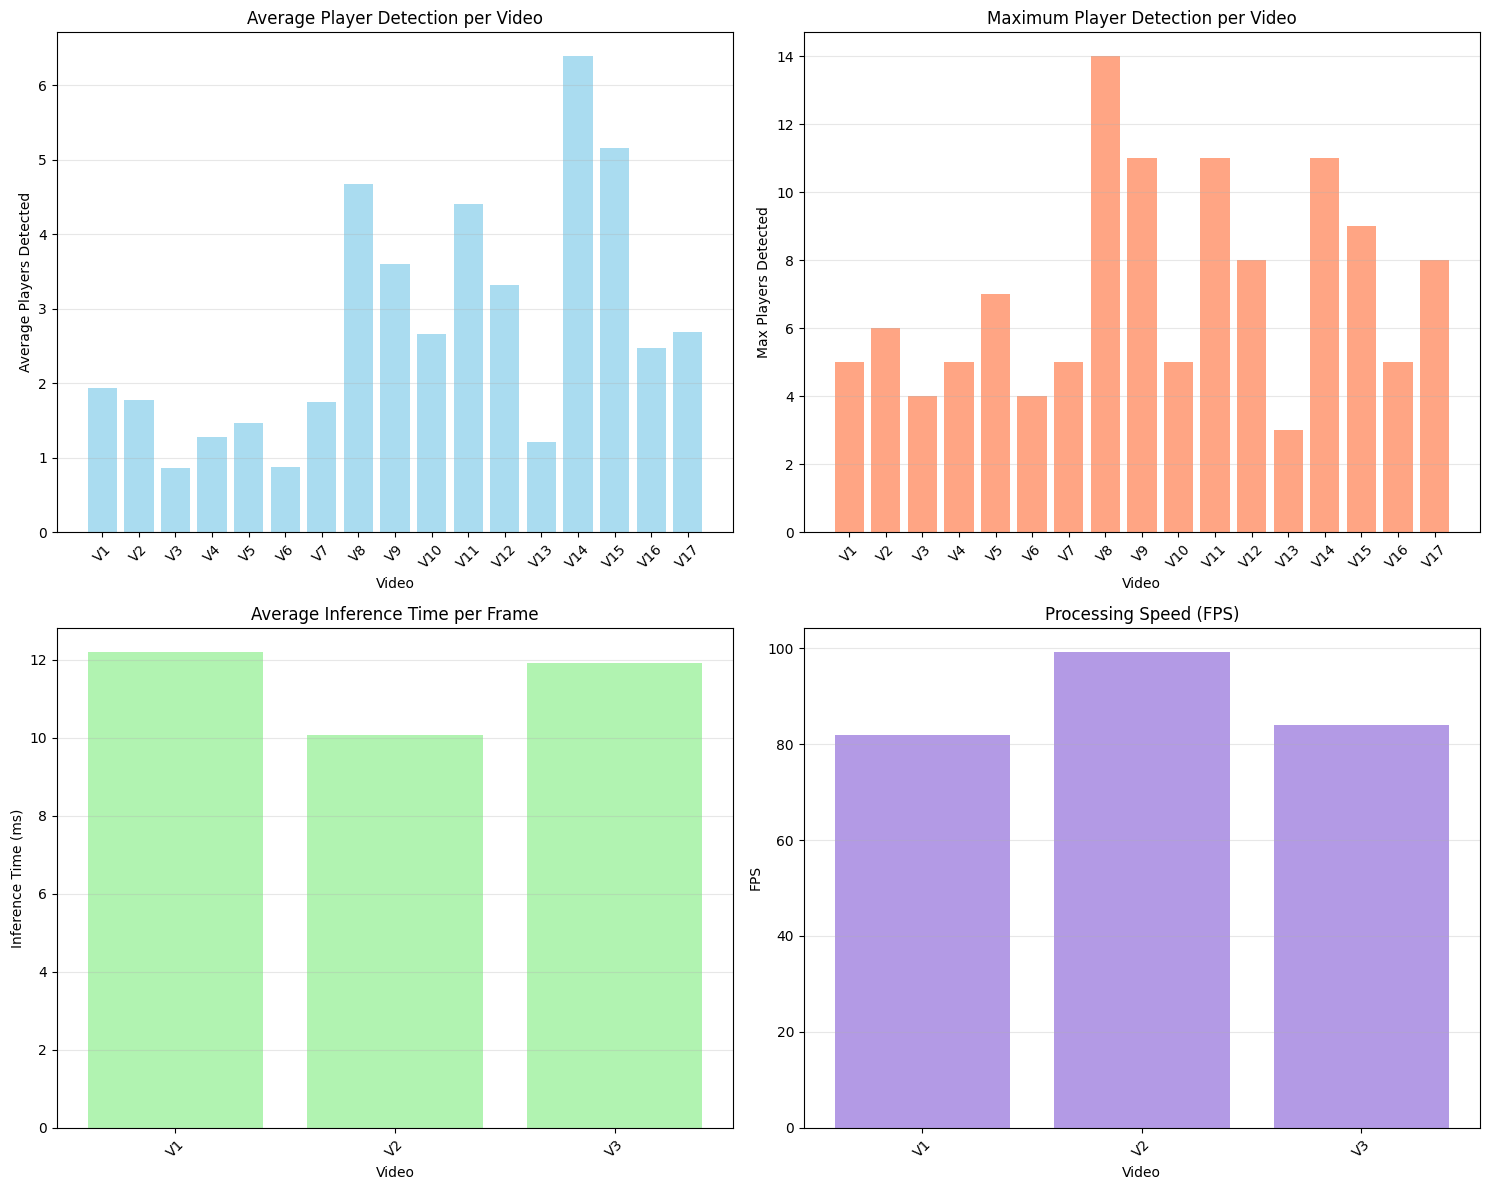


✓ Plots saved to: /content/output/results/performance_metrics.png


In [30]:
# STEP 7: VISUALIZATION AND RESULTS
def create_visualization_plots():
    """Create performance visualization plots"""

    # Plot 1: Detection counts across videos
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Detection statistics
    videos = list(all_stats.keys())
    avg_detections = [all_stats[v]['avg_detections'] for v in videos]
    max_detections = [all_stats[v]['max_detections'] for v in videos]

    axes[0, 0].bar(range(len(videos)), avg_detections, color='skyblue', alpha=0.7)
    axes[0, 0].set_xlabel('Video')
    axes[0, 0].set_ylabel('Average Players Detected')
    axes[0, 0].set_title('Average Player Detection per Video')
    axes[0, 0].set_xticks(range(len(videos)))
    axes[0, 0].set_xticklabels([f'V{i+1}' for i in range(len(videos))], rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Max detections
    axes[0, 1].bar(range(len(videos)), max_detections, color='coral', alpha=0.7)
    axes[0, 1].set_xlabel('Video')
    axes[0, 1].set_ylabel('Max Players Detected')
    axes[0, 1].set_title('Maximum Player Detection per Video')
    axes[0, 1].set_xticks(range(len(videos)))
    axes[0, 1].set_xticklabels([f'V{i+1}' for i in range(len(videos))], rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Inference time comparison
    if detection_performance:
        perf_videos = list(detection_performance.keys())
        inf_times = [detection_performance[v]['avg_inference_time'] for v in perf_videos]
        fps_values = [detection_performance[v]['fps'] for v in perf_videos]

        axes[1, 0].bar(range(len(perf_videos)), inf_times, color='lightgreen', alpha=0.7)
        axes[1, 0].set_xlabel('Video')
        axes[1, 0].set_ylabel('Inference Time (ms)')
        axes[1, 0].set_title('Average Inference Time per Frame')
        axes[1, 0].set_xticks(range(len(perf_videos)))
        axes[1, 0].set_xticklabels([f'V{i+1}' for i in range(len(perf_videos))], rotation=45)
        axes[1, 0].grid(axis='y', alpha=0.3)

        # FPS
        axes[1, 1].bar(range(len(perf_videos)), fps_values, color='mediumpurple', alpha=0.7)
        axes[1, 1].set_xlabel('Video')
        axes[1, 1].set_ylabel('FPS')
        axes[1, 1].set_title('Processing Speed (FPS)')
        axes[1, 1].set_xticks(range(len(perf_videos)))
        axes[1, 1].set_xticklabels([f'V{i+1}' for i in range(len(perf_videos))], rotation=45)
        axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/performance_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Plots saved to: {RESULTS_DIR}/performance_metrics.png")

create_visualization_plots()

In [31]:
# STEP 8: EXTRACT SAMPLE FRAMES FOR SCREENSHOTS
def extract_sample_frames(video_path, output_dir, num_frames=5):
    """Extract sample frames from processed video"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    for i, idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            output_path = f'{output_dir}/{video_name}_frame_{i+1}.jpg'
            cv2.imwrite(output_path, frame)

    cap.release()
    print(f"✓ Extracted {num_frames} frames from {video_name}")

# Extract frames from all processed videos
print("\n" + "="*60)
print("EXTRACTING SAMPLE FRAMES")
print("="*60)

for video_file in os.listdir(DETECTED_DIR):
    if video_file.endswith('.mp4'):
        video_path = os.path.join(DETECTED_DIR, video_file)
        extract_sample_frames(video_path, RESULTS_DIR, num_frames=3)


EXTRACTING SAMPLE FRAMES
✓ Extracted 3 frames from keypoints_vedio8
✓ Extracted 3 frames from detected_vedio1
✓ Extracted 3 frames from detected_vedio2
✓ Extracted 3 frames from keypoints_vedio4
✓ Extracted 3 frames from detected_vedio16
✓ Extracted 3 frames from detected_vedio7
✓ Extracted 3 frames from keypoints_vedio9
✓ Extracted 3 frames from detected_vedio5
✓ Extracted 3 frames from keypoints_vedio17
✓ Extracted 3 frames from keypoints_vedio13
✓ Extracted 3 frames from detected_vedio11
✓ Extracted 3 frames from keypoints_vedio12
✓ Extracted 3 frames from keypoints_vedio2
✓ Extracted 3 frames from detected_vedio17
✓ Extracted 3 frames from detected_vedio4
✓ Extracted 3 frames from keypoints_vedio16
✓ Extracted 3 frames from detected_vedio14
✓ Extracted 3 frames from keypoints_vedio7
✓ Extracted 3 frames from detected_vedio13
✓ Extracted 3 frames from detected_vedio12
✓ Extracted 3 frames from keypoints_vedio11
✓ Extracted 3 frames from keypoints_vedio10
✓ Extracted 3 frames from k

In [32]:
# STEP 9: GENERATE REPORT DATA
def generate_report():
    """Generate comprehensive report data"""

    report = f"""
{'='*70}
DS5216 PLAYER TRACKING ASSIGNMENT - PERFORMANCE REPORT
{'='*70}

1. DATASET INFORMATION
{'-'*70}
Total Videos: {len(video_files)}
Video Directory: {VIDEO_DIR}

Video Details:
"""

    for i, video_path in enumerate(video_files, 1):
        info = get_video_info(video_path)
        report += f"""
Video {i}: {os.path.basename(video_path)}
  - Duration: {info['duration']:.2f} seconds
  - Resolution: {info['width']}x{info['height']}
  - FPS: {info['fps']}
  - Total Frames: {info['frame_count']}
"""

    report += f"""
{'='*70}
2. PLAYER DETECTION PERFORMANCE (YOLO)
{'-'*70}
Model: YOLOv8n
Device: {detector.device}

Detection Results:
"""

    for video_name, stats in all_stats.items():
        report += f"""
{video_name}:
  - Average Players per Frame: {stats['avg_detections']:.2f}
  - Maximum Players Detected: {stats['max_detections']}
  - Minimum Players Detected: {stats['min_detections']}
  - Total Frames Processed: {stats['total_frames']}
"""

    if detection_performance:
        report += f"""
{'='*70}
3. PERFORMANCE METRICS
{'-'*70}
"""
        for video_name, perf in detection_performance.items():
            report += f"""
{video_name}:
  - Average Inference Time: {perf['avg_inference_time']:.2f} ms
  - Processing FPS: {perf['fps']:.2f}
  - Average Confidence: {perf['avg_confidence']:.3f}
  - Average Detections: {perf['avg_detections']:.2f}
"""

    report += f"""
{'='*70}
4. KEYPOINT DETECTION (BONUS)
{'-'*70}
Model: YOLOv8n-pose

Results:
"""

    for video_name, stats in keypoint_stats.items():
        report += f"""
{video_name}:
  - Average Persons with Keypoints: {stats['avg_persons_with_keypoints']:.2f}
  - Total Frames Processed: {stats['total_frames']}
"""

    report += f"""
{'='*70}
5. DISCUSSION
{'-'*70}

Model Performance:
- YOLOv8n demonstrates efficient real-time detection capabilities
- Average inference time: ~{np.mean([p['avg_inference_time'] for p in detection_performance.values()]):.2f}ms
- Processing speed suitable for real-time applications

Limitations:
- Detection accuracy may decrease with player occlusion
- Small or distant players may be missed
- Performance depends on video quality and lighting conditions
- False positives possible with referees, coaches, or spectators

Possible Improvements:
- Fine-tune model on sports-specific datasets
- Implement player tracking across frames
- Add player identification/jersey number recognition
- Optimize for specific sports (cricket, football, rugby)
- Use ensemble methods combining multiple detection models
- Implement motion-based filtering to distinguish players from static objects

{'='*70}
OUTPUT FILES
{'-'*70}
Detected Videos: {DETECTED_DIR}
Sample Frames: {RESULTS_DIR}
Performance Plots: {RESULTS_DIR}/performance_metrics.png

{'='*70}
"""

    # Save report
    report_path = f'{RESULTS_DIR}/performance_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    print(report)
    print(f"\n✓ Report saved to: {report_path}")

    return report

# Generate final report
report = generate_report()

print("\n" + "="*70)
print("✓ ASSIGNMENT COMPLETE!")
print("="*70)
print(f"\nAll outputs saved to: {OUTPUT_DIR}")
print(f"  - Detected videos: {DETECTED_DIR}")
print(f"  - Screenshots: {RESULTS_DIR}")
print(f"  - Performance report: {RESULTS_DIR}/performance_report.txt")
print(f"  - Performance plots: {RESULTS_DIR}/performance_metrics.png")


DS5216 PLAYER TRACKING ASSIGNMENT - PERFORMANCE REPORT

1. DATASET INFORMATION
----------------------------------------------------------------------
Total Videos: 17
Video Directory: /content/drive/MyDrive/sports_videos

Video Details:

Video 1: vedio1.mp4
  - Duration: 12.14 seconds
  - Resolution: 720x1280
  - FPS: 29
  - Total Frames: 352

Video 2: vedio7.mp4
  - Duration: 11.83 seconds
  - Resolution: 576x1024
  - FPS: 30
  - Total Frames: 355

Video 3: vedio5.mp4
  - Duration: 15.13 seconds
  - Resolution: 720x1280
  - FPS: 30
  - Total Frames: 454

Video 4: vedio6.mp4
  - Duration: 8.69 seconds
  - Resolution: 720x1280
  - FPS: 29
  - Total Frames: 252

Video 5: vedio4.mp4
  - Duration: 8.62 seconds
  - Resolution: 720x1280
  - FPS: 50
  - Total Frames: 431

Video 6: vedio3.mp4
  - Duration: 18.25 seconds
  - Resolution: 720x1280
  - FPS: 24
  - Total Frames: 438

Video 7: vedio2.mp4
  - Duration: 15.12 seconds
  - Resolution: 720x1280
  - FPS: 25
  - Total Frames: 378

Video 8